# Se på ord i data

In [1]:
import pandas as pd

metadata_df = pd.read_csv("../data/samisk_ocr_line_level_dataset/metadata.csv")

train_df = metadata_df[metadata_df.file_name.apply(lambda x: x.startswith("train"))]

manual_train_df = train_df[~train_df.page_30 & ~train_df.gt_pix]
page_30_df = train_df[train_df.page_30]
gt_pix_df = train_df[train_df.gt_pix]
val_df = metadata_df[metadata_df.file_name.apply(lambda x: x.startswith("val"))]

In [2]:
from ast import literal_eval
from collections import defaultdict


def print_language_overview(df: pd.DataFrame):
    lang_len = defaultdict(int)
    for langcodes, df_ in df.groupby("langcodes"):
        langcodes = literal_eval(langcodes)
        if len(langcodes) > 1:
            for langcode in langcodes:
                lang_len[langcode] += len(df_) / 2

        lang_len[langcodes[0]] += len(df_)
    for lang, num in lang_len.items():
        print(f"Språk: {lang}\nAntall linjer: {num} ({round(num/len(df)*100, 2)}%)")
    print("\n")


print("Treningssett språkoversikt\n")
print_language_overview(manual_train_df)

print("Valideringssett språkoversikt\n")
print_language_overview(val_df)


print("Side 30 språkoversikt\n")
print_language_overview(page_30_df)

Treningssett språkoversikt

Språk: sma
Antall linjer: 208 (3.23%)
Språk: sme
Antall linjer: 5871.0 (91.16%)
Språk: smj
Antall linjer: 81 (1.26%)
Språk: smn
Antall linjer: 338.0 (5.25%)


Valideringssett språkoversikt

Språk: sma
Antall linjer: 53 (2.58%)
Språk: sme
Antall linjer: 1854 (90.35%)
Språk: smj
Antall linjer: 36 (1.75%)
Språk: smn
Antall linjer: 109 (5.31%)


Side 30 språkoversikt

Språk: sma
Antall linjer: 7082 (8.4%)
Språk: sme
Antall linjer: 70413 (83.55%)
Språk: smj
Antall linjer: 6781 (8.05%)




In [3]:
len(metadata_df), len(manual_train_df), len(gt_pix_df), len(gt_pix_df), len(val_df)

(96557, 6440, 2998, 2998, 2052)

In [4]:
from collections import Counter

from nb_tokenizer import tokenize


def get_tokens(df: pd.DataFrame) -> Counter[str]:
    tokens = [t for text_line in df.text for t in tokenize(str(text_line))]
    return Counter(tokens)


train_tokens = get_tokens(manual_train_df)
s_30_tokens = get_tokens(page_30_df)
gt_pix_tokens = get_tokens(gt_pix_df)
val_tokens = get_tokens(val_df)

In [5]:
print(f"""Unike tokens:
    Train:      {'{:_}'.format(len(train_tokens))}
    Val:        {'{:_}'.format(len(val_tokens))}
    Side 30:    {'{:_}'.format(len(s_30_tokens))}
    GT pix:     {'{:_}'.format(len(gt_pix_tokens))}
""")

Unike tokens:
    Train:      10_229
    Val:        5_176
    Side 30:    110_934
    GT pix:     7_895



In [6]:
print(f"""Totalt antall tokens:
    Train:      {'{:_}'.format(sum(train_tokens.values()))}
    Side 30:    {'{:_}'.format(sum(s_30_tokens.values()))}
    Val:        {'{:_}'.format(sum(val_tokens.values()))}
    GT pix:     {'{:_}'.format(sum(gt_pix_tokens.values()))}

""")

Totalt antall tokens:
    Train:      33_141
    Side 30:    523_907
    Val:        11_920
    GT pix:     27_809




In [7]:
from typing import Any, Iterable


def percent_overlap(container1: Iterable[Any], container2: Iterable[Any]) -> float:
    intersection_len = len(set(container1).intersection(set(container2)))
    intersection_part = intersection_len / len(container1)
    return round(intersection_part * 100, 2)

In [8]:
print(f"""Tokenoverlapp
      
    Train og val:      
        {percent_overlap(val_tokens, train_tokens)}% av tokensa i val finnes i train
        {percent_overlap(train_tokens, val_tokens)}% av tokensa i train finnes i val

    Train og side 30:   
        {percent_overlap(train_tokens, s_30_tokens)}% av tokensa i train finnes i side 30
        {percent_overlap(s_30_tokens, train_tokens)}% av tokensa i side 30 finnes i train 
        
    Val og side 30:   
        {percent_overlap(val_tokens, s_30_tokens)}% av tokensa i val finnes i side 30
        {percent_overlap(s_30_tokens, val_tokens)}% av tokensa i side 30 finnes i val       
-----
    Train og GT pix:   
        {percent_overlap(train_tokens, gt_pix_tokens)}% av tokensa i train finnes i GT pix
        {percent_overlap(gt_pix_tokens, train_tokens)}% av tokensa i GT pix finnes i train 
        
    Val og GT pix:   
        {percent_overlap(val_tokens, gt_pix_tokens)}% av tokensa i val finnes i GT pix
        {percent_overlap(gt_pix_tokens, val_tokens)}% av tokensa i GT pix finnes i val       
      
""")

Tokenoverlapp
      
    Train og val:      
        25.97% av tokensa i val finnes i train
        13.14% av tokensa i train finnes i val

    Train og side 30:   
        48.53% av tokensa i train finnes i side 30
        4.47% av tokensa i side 30 finnes i train 
        
    Val og side 30:   
        57.44% av tokensa i val finnes i side 30
        2.68% av tokensa i side 30 finnes i val       
-----
    Train og GT pix:   
        4.85% av tokensa i train finnes i GT pix
        6.28% av tokensa i GT pix finnes i train 
        
    Val og GT pix:   
        4.97% av tokensa i val finnes i GT pix
        3.26% av tokensa i GT pix finnes i val       
      



## Forskjeller i tokens mellom settene

In [9]:
print(
    f"Antall tokens som bare fins i side 30:    {len(set(s_30_tokens) - (set(train_tokens).union(set(val_tokens).union(set(gt_pix_tokens)))))}"
)
print(
    f"Antall tokens som bare fins i GT pix:     {len(set(gt_pix_tokens) - set(s_30_tokens).union(set(train_tokens)).union(set(val_tokens)))}"
)
print(
    f"Antall tokens som bare fins i train:      {len(set(train_tokens) - set(s_30_tokens).union(set(val_tokens)).union(set(gt_pix_tokens)))}"
)
print(
    f"Antall tokens som bare fins i val:        {len(set(val_tokens) - set(s_30_tokens).union(set(train_tokens)).union(set(gt_pix_tokens)))}"
)

Antall tokens som bare fins i side 30:    102415
Antall tokens som bare fins i GT pix:     5490
Antall tokens som bare fins i train:      5149
Antall tokens som bare fins i val:        2108


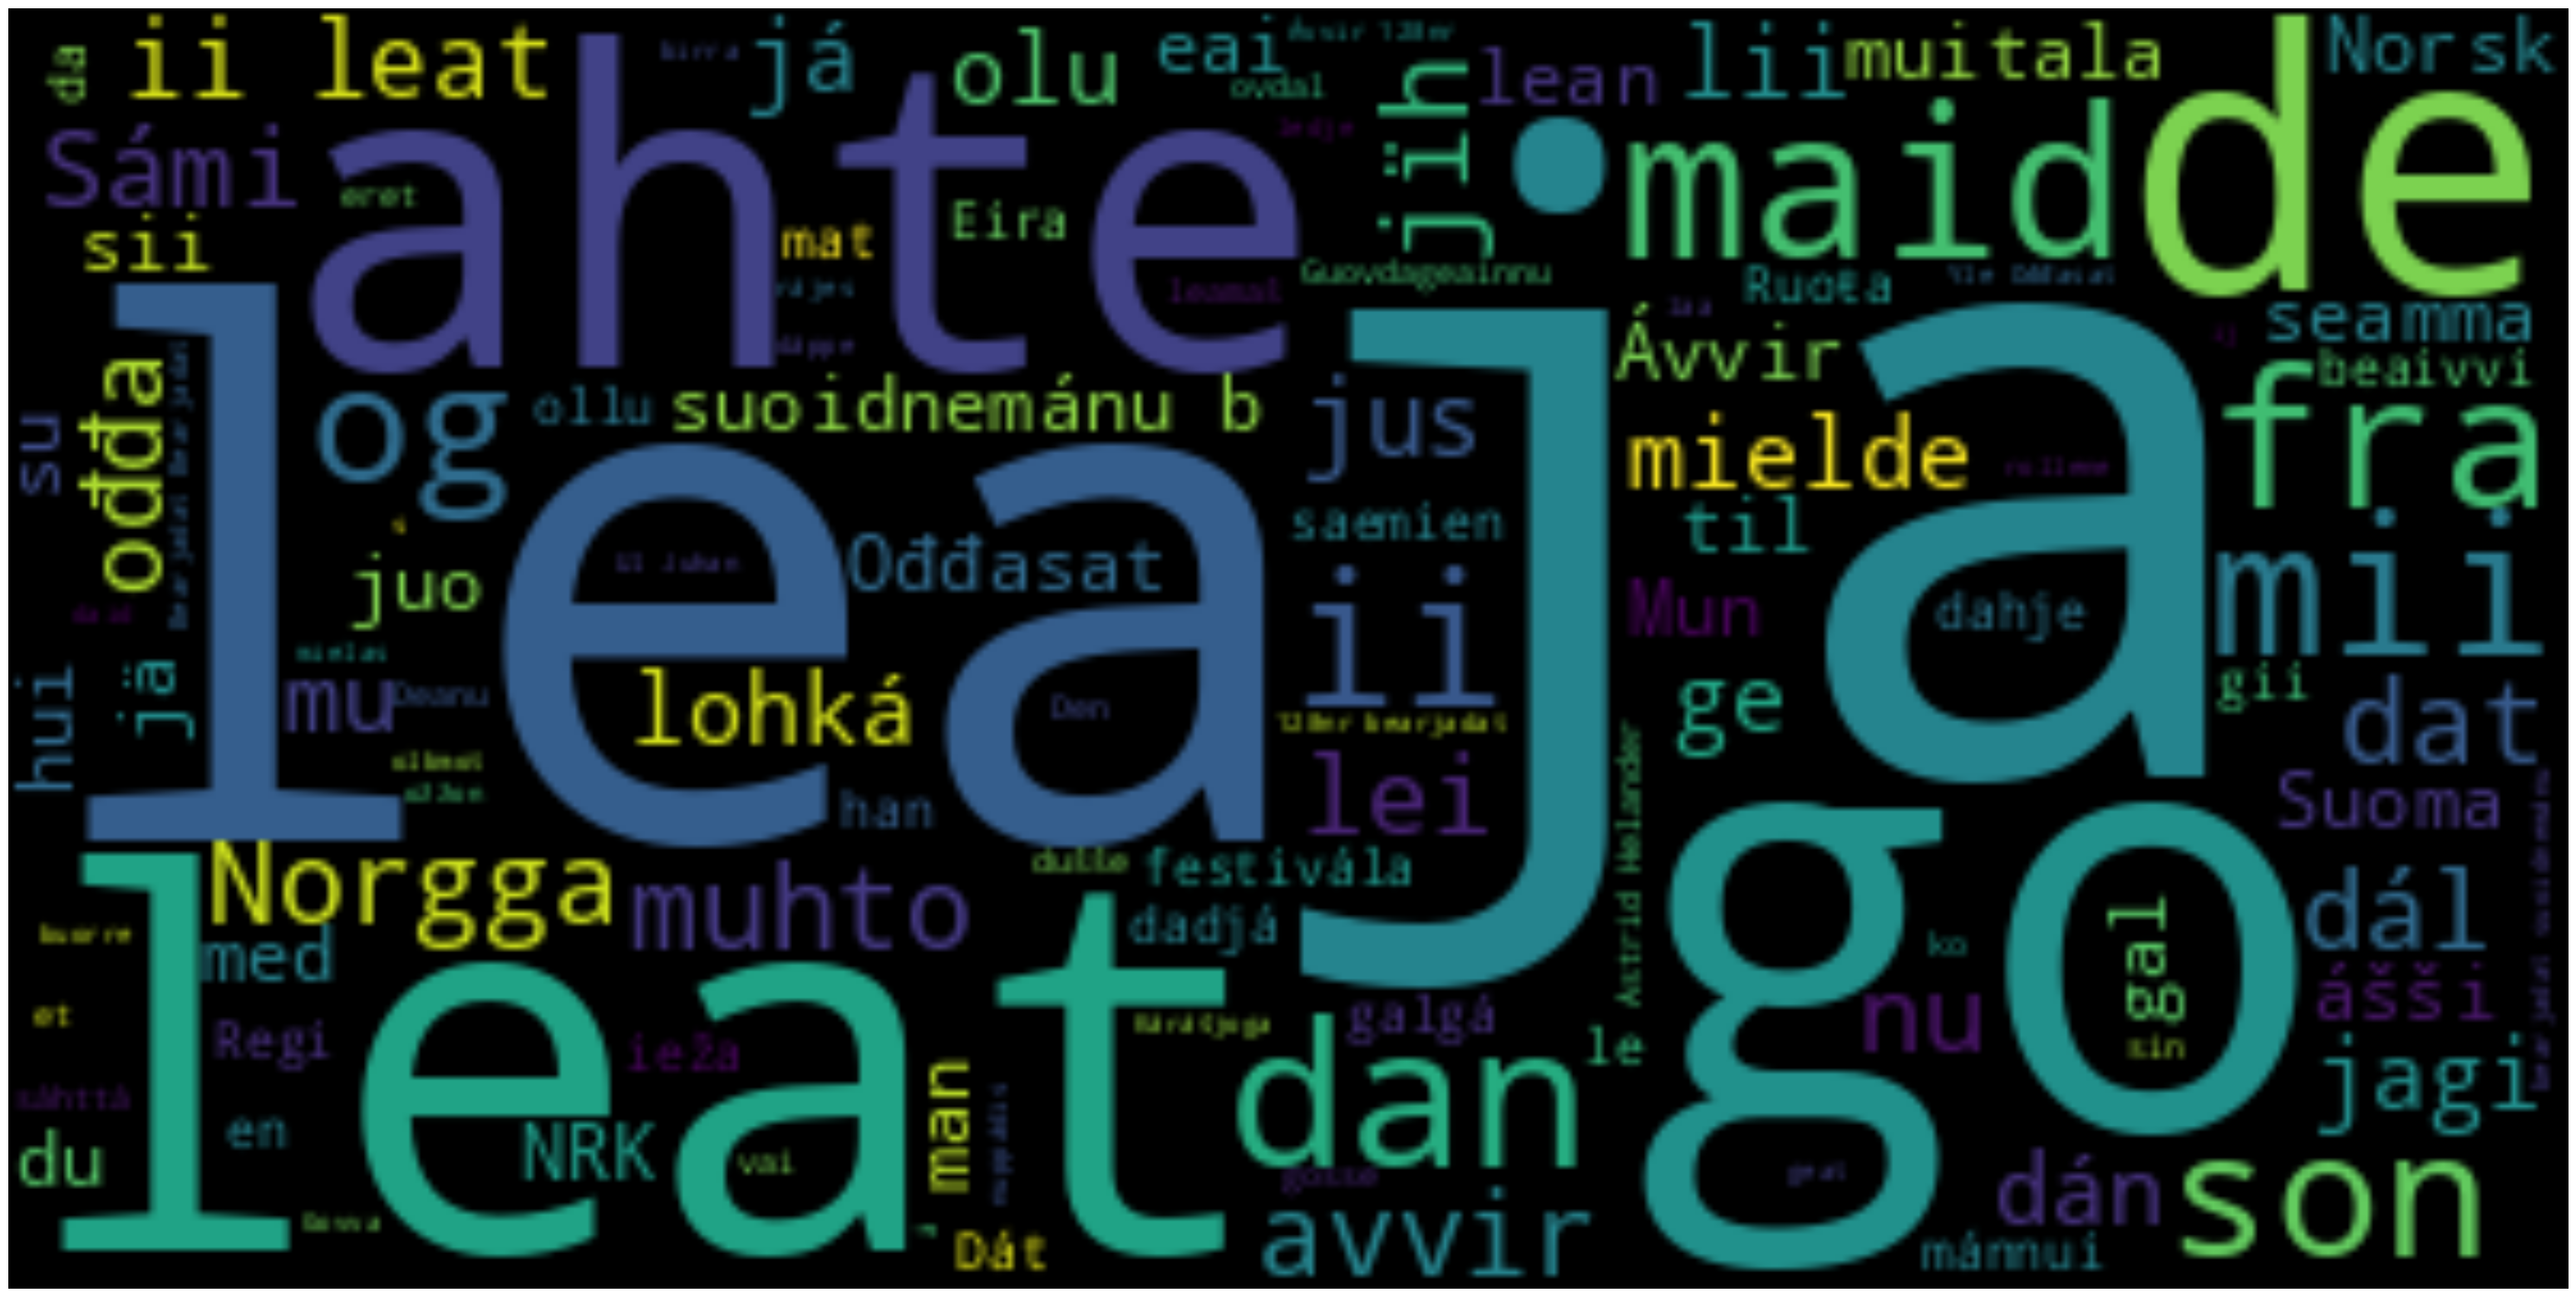

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud


def get_text(df: pd.DataFrame) -> str:
    all_text = ""
    for text in df.text:
        all_text += f" {text}"
    return all_text


train_text = get_text(manual_train_df)
train_cloud = WordCloud().generate(train_text)
plt.figure(figsize=(60, 20))
plt.imshow(train_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

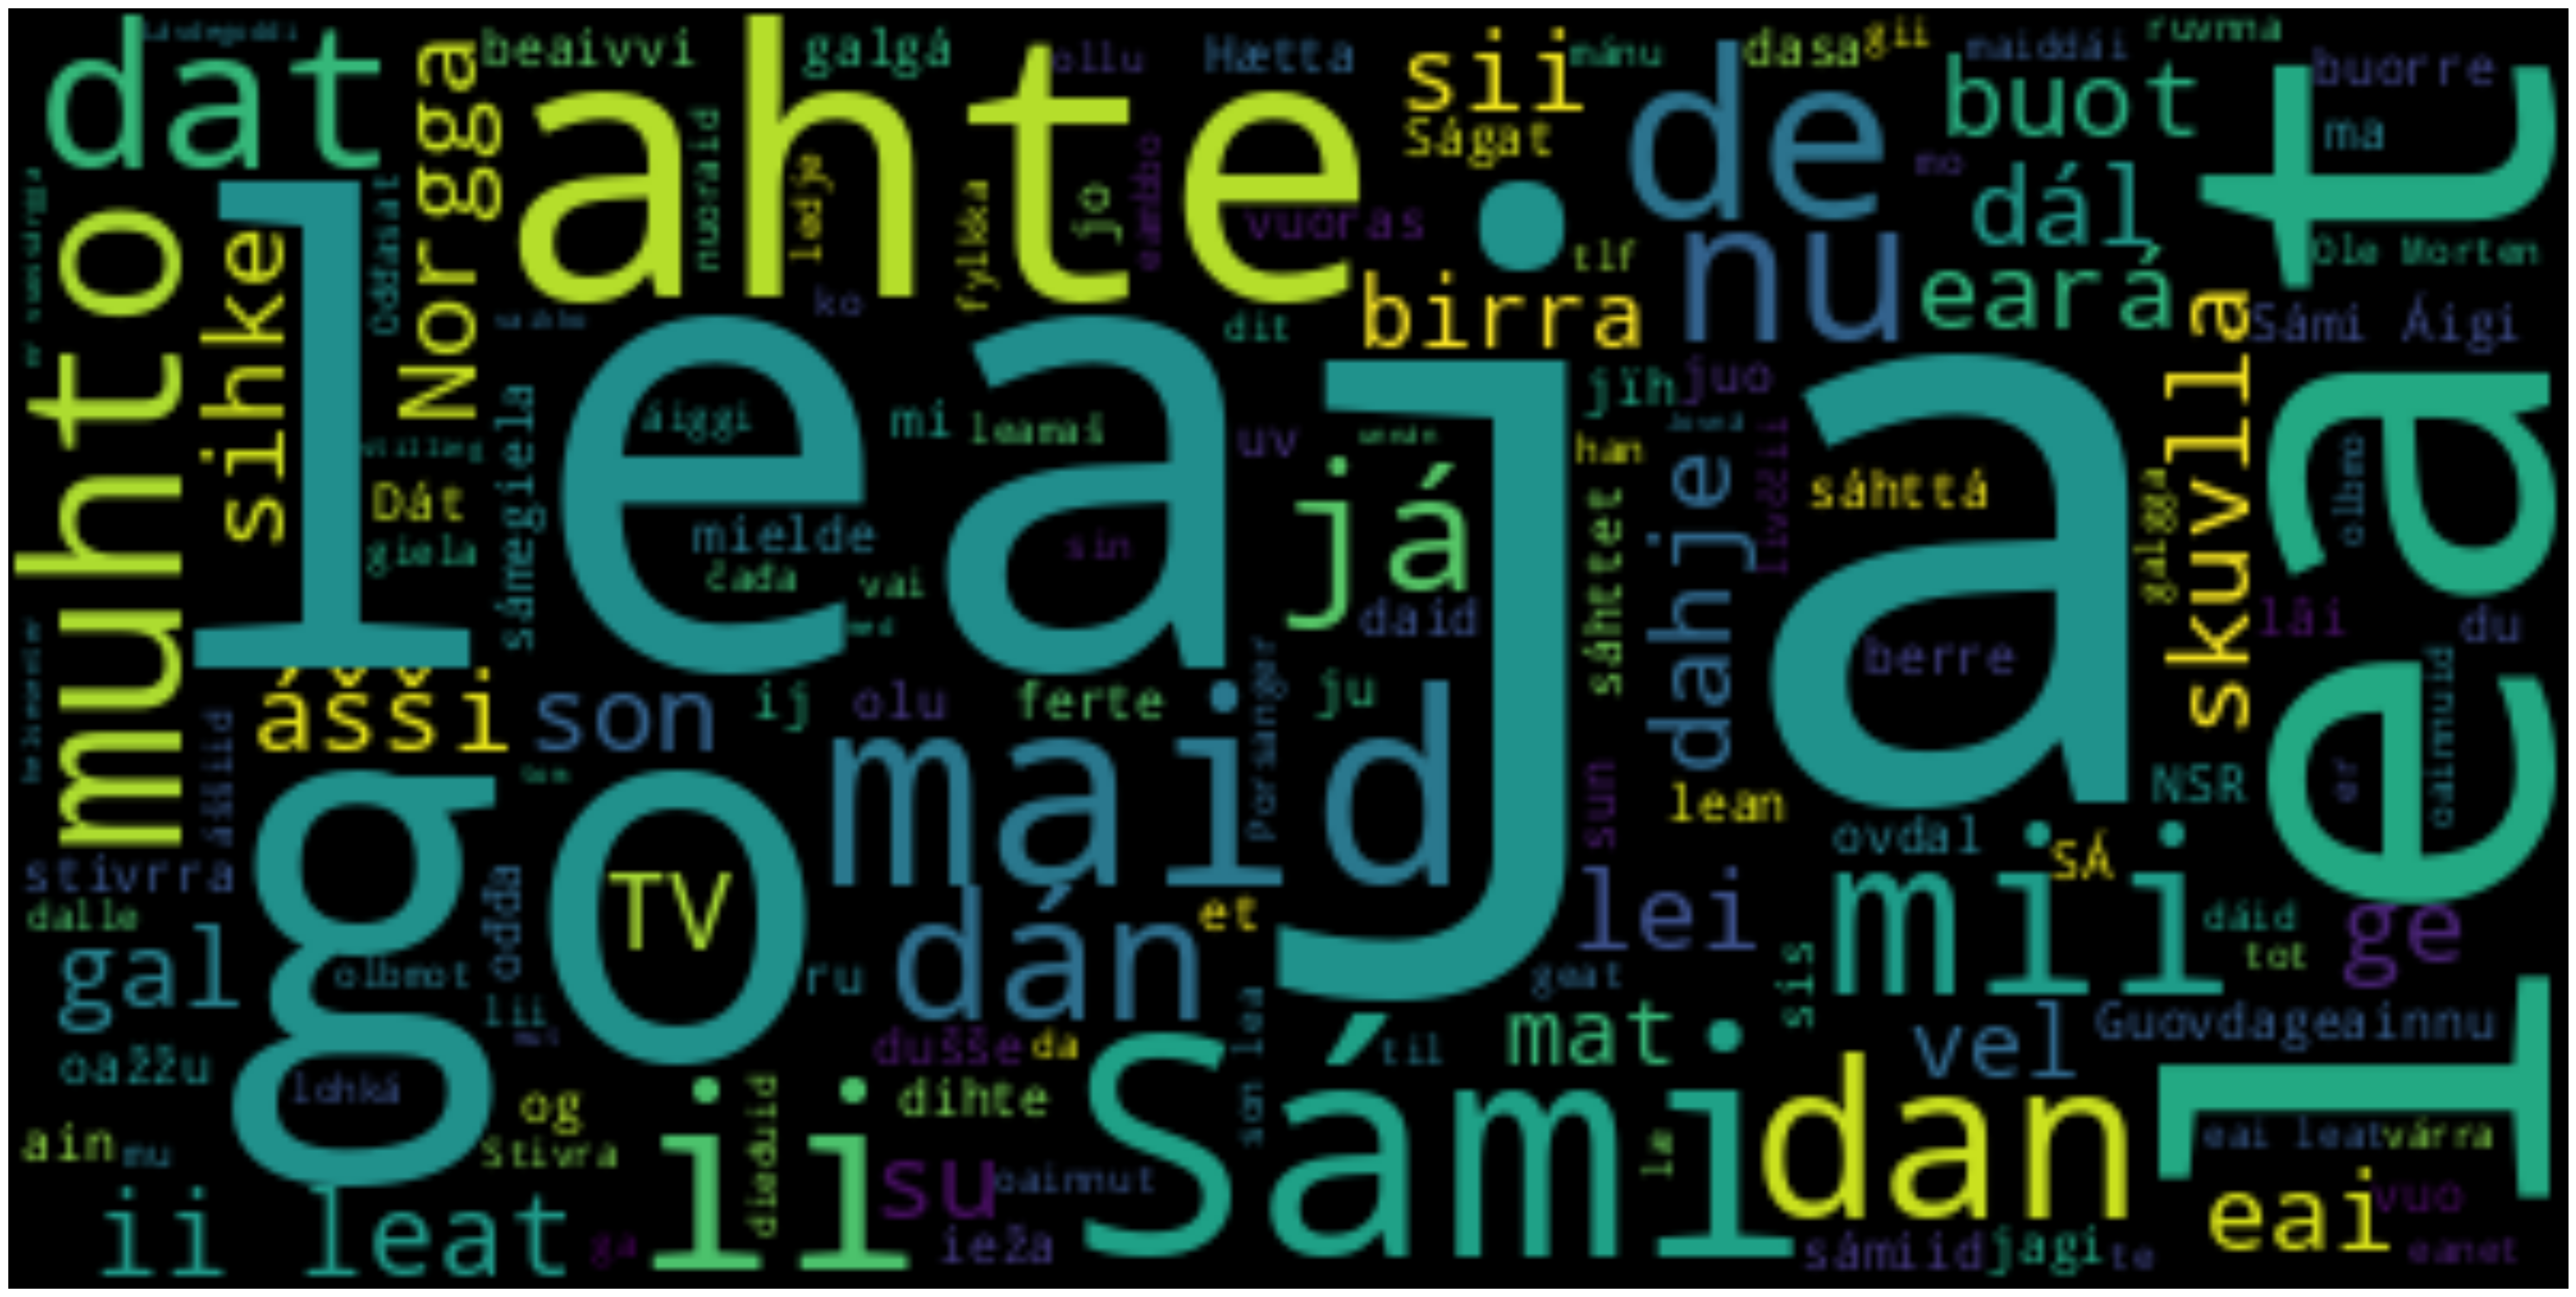

In [11]:
val_text = get_text(val_df)
val_cloud = WordCloud().generate(val_text)
plt.figure(figsize=(60, 20))
plt.imshow(val_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

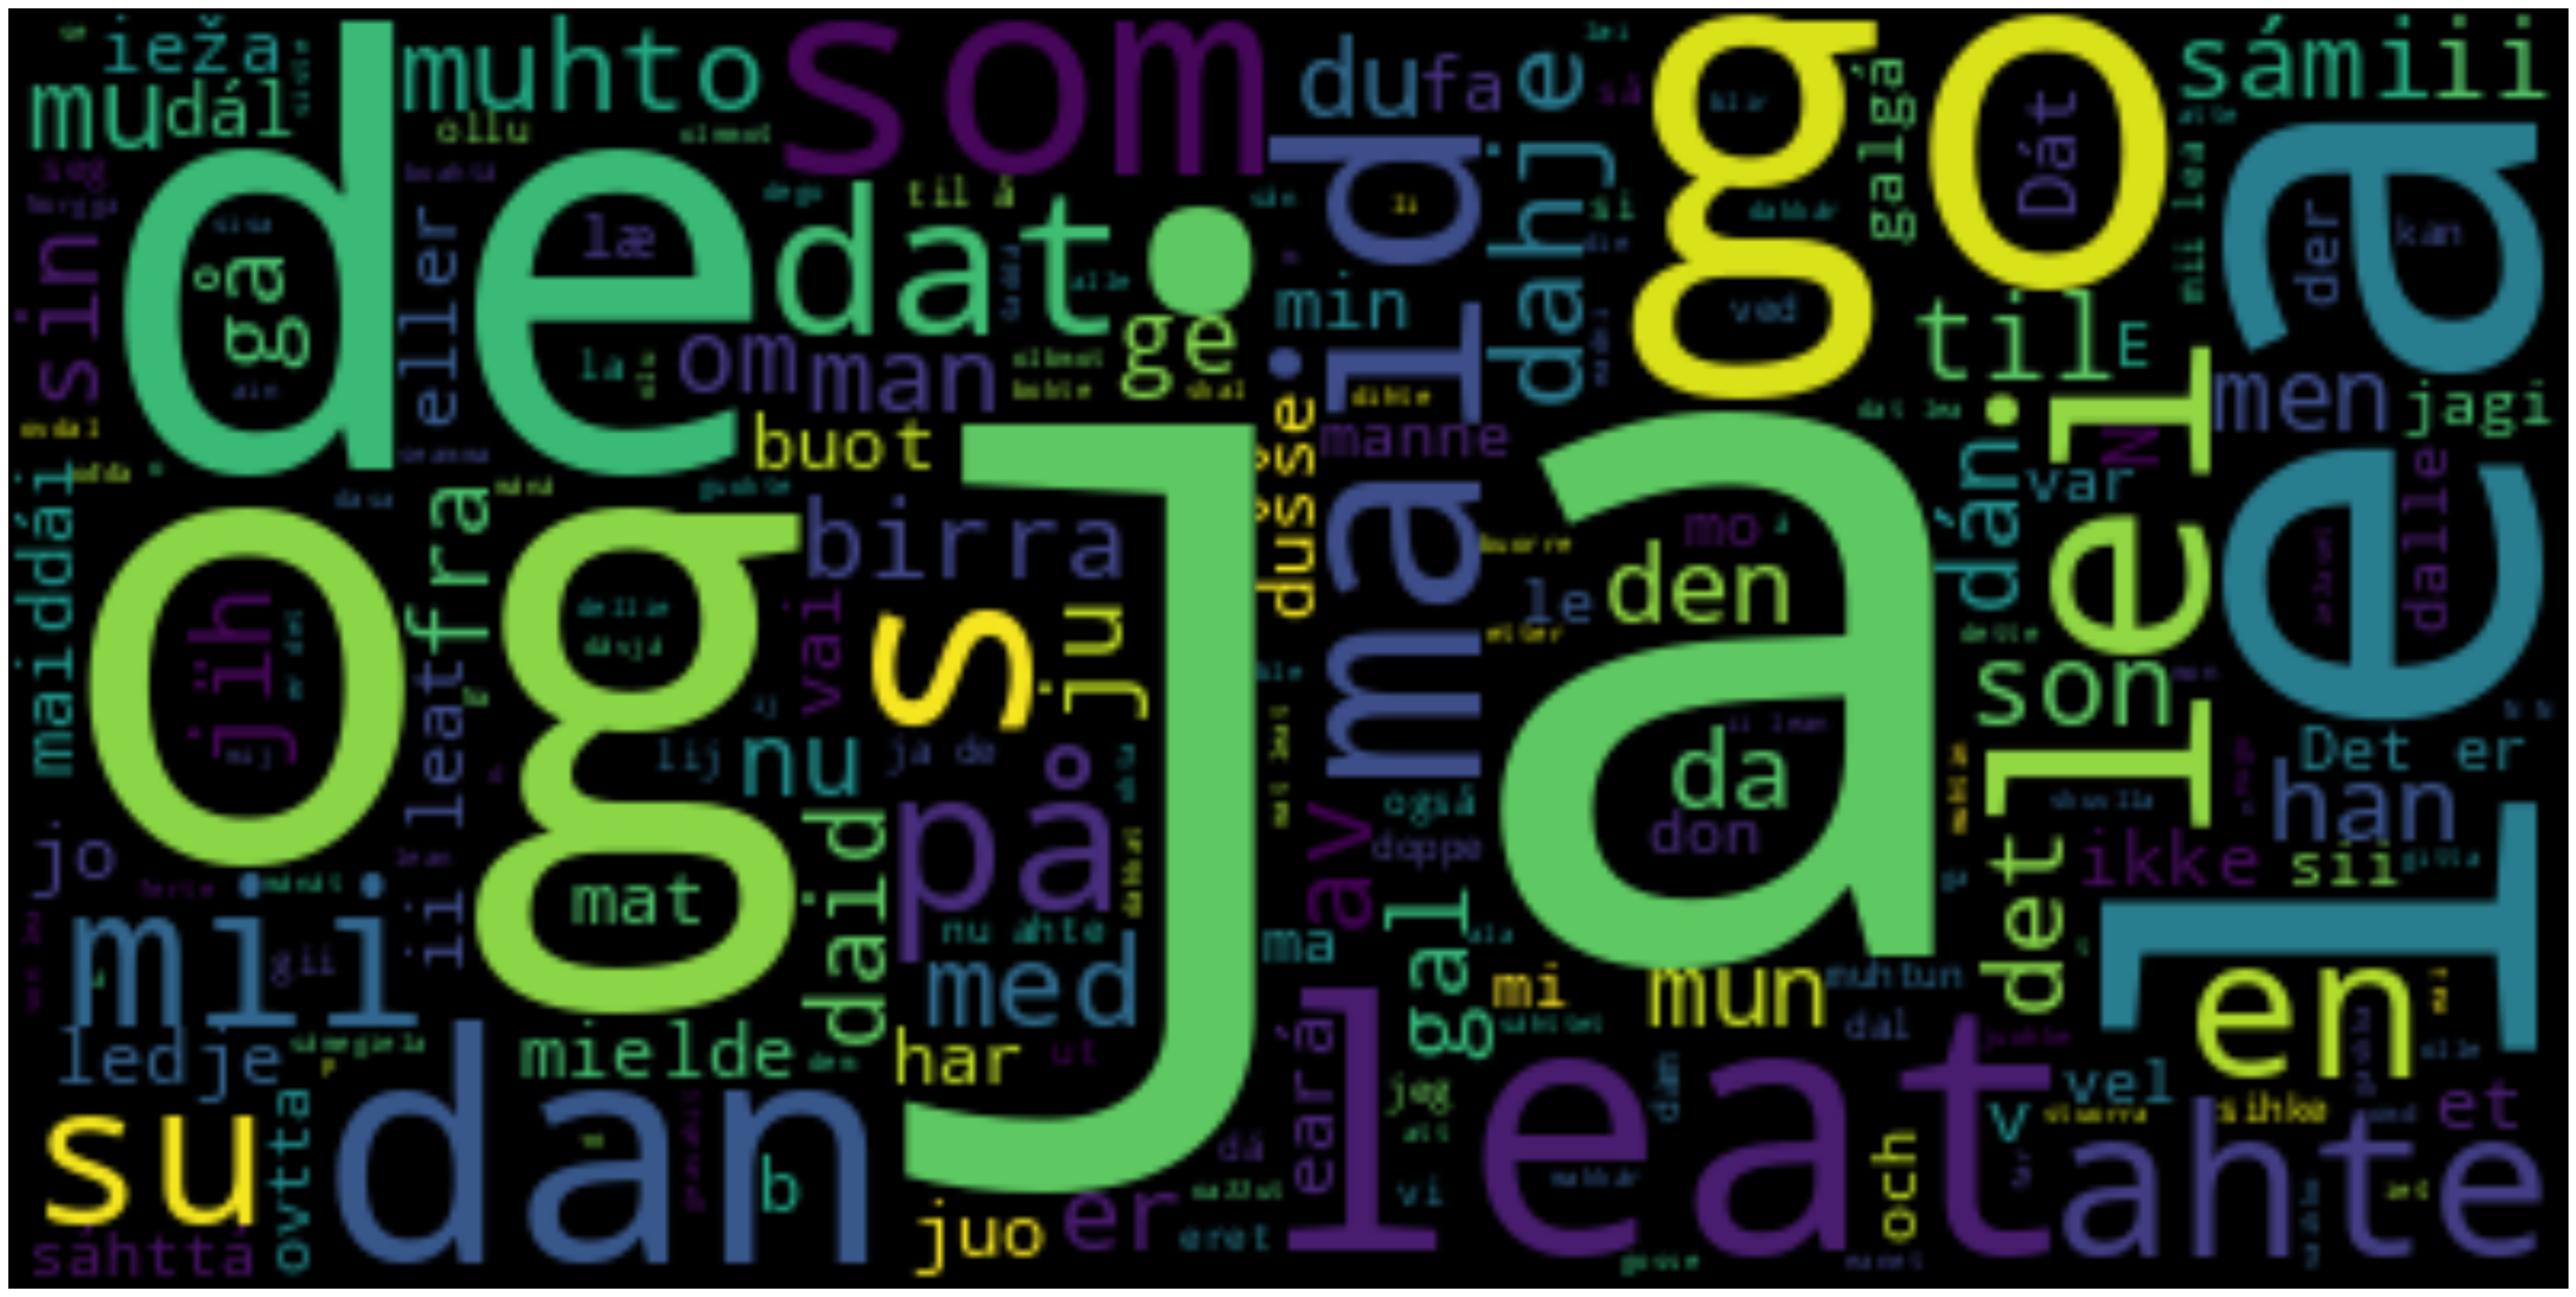

In [12]:
p_30_text = get_text(page_30_df)
p_30_cloud = WordCloud().generate(p_30_text)
plt.figure(figsize=(60, 20))
plt.imshow(p_30_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

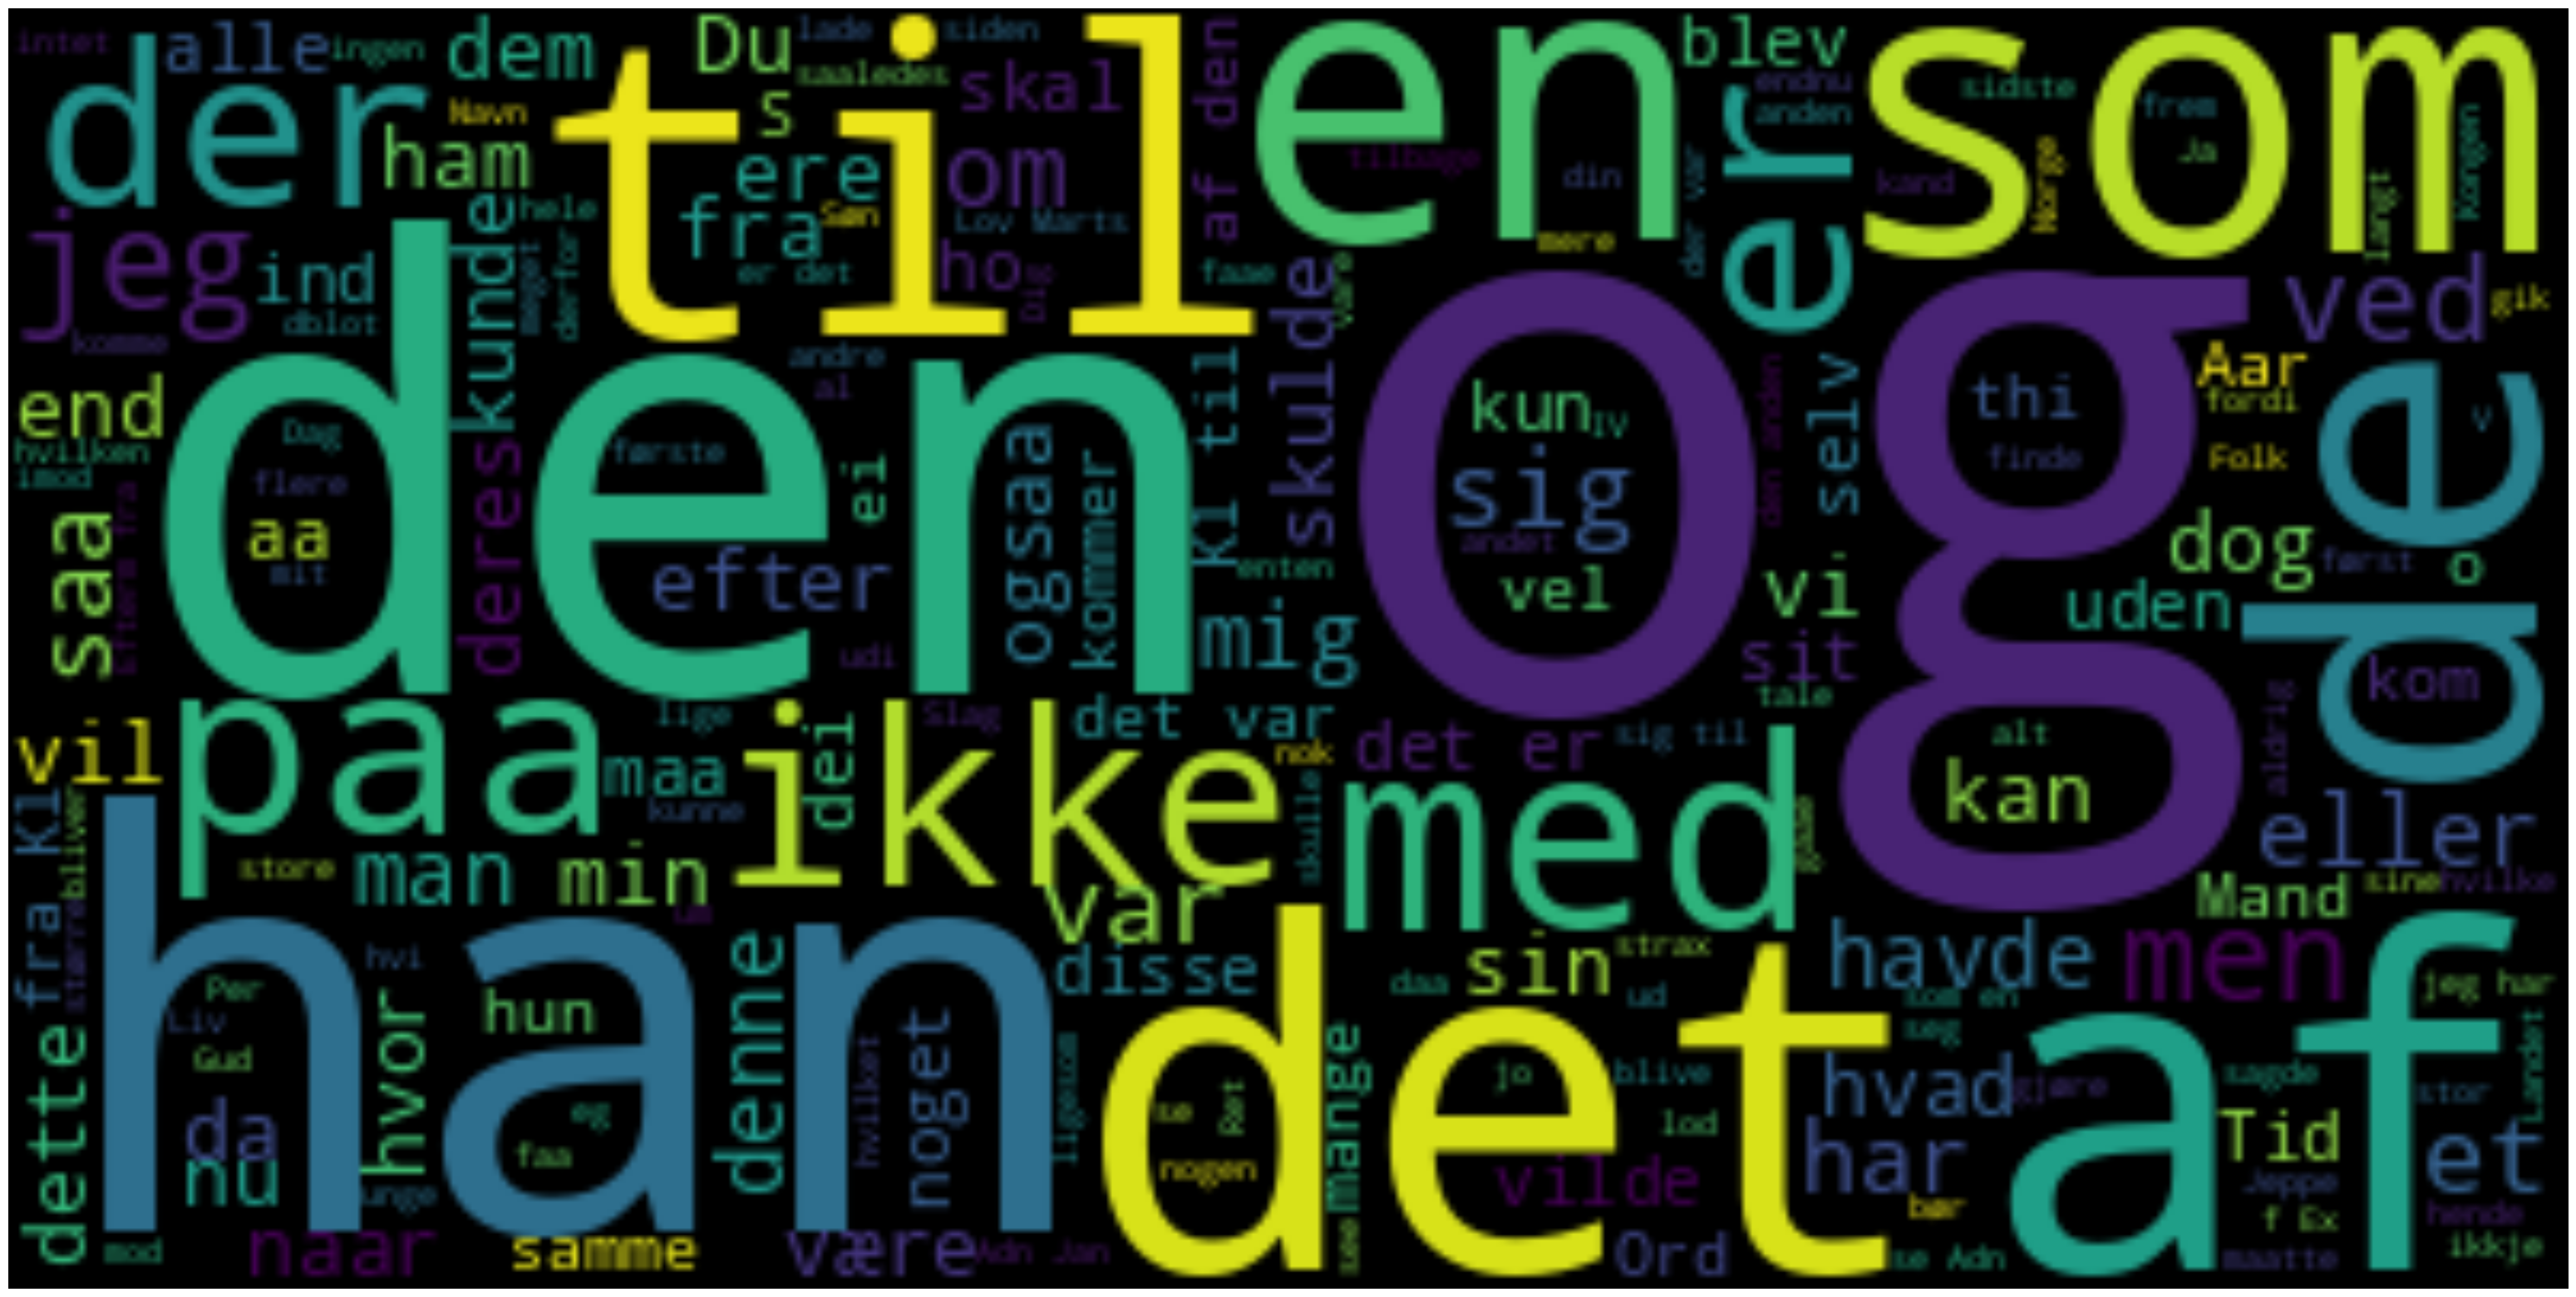

In [13]:
gt_pix_text = get_text(gt_pix_df)
gt_pix_cloud = WordCloud().generate(gt_pix_text)
plt.figure(figsize=(60, 20))
plt.imshow(gt_pix_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Se på bokstaver og tegn i data

In [14]:
train_chars = Counter(train_text)
s_30_chars = Counter(p_30_text)
val_chars = Counter(val_text)
gt_pix_chars = Counter(gt_pix_text)

print(f"""Unike tegn:
    Train:      {'{:_}'.format(len(train_chars))}
    Val:        {'{:_}'.format(len(val_chars))}
    Side 30:    {'{:_}'.format(len(s_30_chars))}
    GT pix:     {'{:_}'.format(len(gt_pix_chars))}

""")

print(f"""Totalt antall tegn:
    Train:      {'{:_}'.format(sum(train_chars.values()))}
    Side 30:    {'{:_}'.format(sum(s_30_chars.values()))}
    Val:        {'{:_}'.format(sum(val_chars.values()))}
    GT pix:     {'{:_}'.format(sum(gt_pix_chars.values()))}

""")

print(f"""Tegnoverlapp
      
    Train og val:      
        {percent_overlap(val_chars, train_chars)}% av tegna i val finnes i train
        {percent_overlap(train_chars, val_chars)}% av tegna i train finnes i val

    Train og side 30:   
        {percent_overlap(train_chars, s_30_chars)}% av tegna i train finnes i side 30
        {percent_overlap(s_30_chars, train_chars)}% av tegna i side 30 finnes i train 

    Val og side 30:   
        {percent_overlap(val_chars, s_30_chars)}% av tegna i val finnes i side 30
        {percent_overlap(s_30_chars, val_chars)}% av tegna i side 30 finnes i val   

----

    Train og GT pix:   
        {percent_overlap(train_chars, gt_pix_chars)}% av tegna i train finnes i GT pix
        {percent_overlap(gt_pix_chars, train_chars)}% av tegna i GT pix finnes i train       
      

    Val og GT pix:   
        {percent_overlap(val_chars, gt_pix_chars)}% av tegna i val finnes i GT pix
        {percent_overlap(gt_pix_chars, val_chars)}% av tegna i GT pix finnes i val       
      
""")

Unike tegn:
    Train:      126
    Val:        108
    Side 30:    139
    GT pix:     122


Totalt antall tegn:
    Train:      189_395
    Side 30:    2_984_651
    Val:        74_057
    GT pix:     136_031


Tegnoverlapp
      
    Train og val:      
        94.44% av tegna i val finnes i train
        80.95% av tegna i train finnes i val

    Train og side 30:   
        95.24% av tegna i train finnes i side 30
        86.33% av tegna i side 30 finnes i train 

    Val og side 30:   
        97.22% av tegna i val finnes i side 30
        75.54% av tegna i side 30 finnes i val   

----

    Train og GT pix:   
        75.4% av tegna i train finnes i GT pix
        77.87% av tegna i GT pix finnes i train       
      

    Val og GT pix:   
        78.7% av tegna i val finnes i GT pix
        69.67% av tegna i GT pix finnes i val       
      



In [15]:
with open("../data/valset_characters.txt", "w+") as f:
    f.write("".join(sorted(list(val_chars))))

## Forskjeller i tegn mellom settene

In [16]:
print(
    f"Bare i side 30: {list(set(s_30_chars) - (set(train_chars).union(set(val_chars)).union(set(gt_pix_chars))))}"
)

Bare i side 30: ['ʹ', 'ǩ', 'ǧ']


In [17]:
print(
    f"Bare i train {list(set(train_chars) - set(s_30_chars).union(set(val_chars)).union(gt_pix_chars))}"
)

Bare i train ['Đ', 'Ž', '€', '√', 'û', '©']


In [18]:
print(
    f"Bare i val {list(set(val_chars) - set(s_30_chars).union(set(train_chars)).union(gt_pix_chars))}"
)

Bare i val ['Ɖ', '_', 'ô']


In [19]:
print(
    f"Bare i GT pix {list(set(gt_pix_chars) - set(s_30_chars).union(set(train_chars)).union(val_chars))}"
)

Bare i GT pix ['ç', 'ɔ', '□', 'Þ', 'ú', '⁴', 'þ', 'í', '”', '⁷', '⁶', '⅒', '½']


# Hmmm hvorfor er D med strek bare i train OG bare i val?? 

In [20]:
elfdal_d = "Ð"
african_d = "Ɖ"
skolt_d = "Đ"

assert elfdal_d != african_d != skolt_d

print(val_chars[elfdal_d], train_chars[elfdal_d])
print(val_chars[african_d], train_chars[african_d])
print(val_chars[skolt_d], train_chars[skolt_d])

6 43
2 0
0 21


In [21]:
all_chars = sorted(list(set(train_chars).union(set(val_chars))))
unicode_code_points = [f"{ord(char):04X}" for char in all_chars]
links = [
    f"https://util.unicode.org/UnicodeJsps/character.jsp?a={code_point}"
    for code_point in unicode_code_points
]

In [22]:
val_counts = [val_chars[char] for char in all_chars]
train_counts = [train_chars[char] for char in all_chars]

In [23]:
df = pd.DataFrame(
    {
        "tegn": all_chars,
        "link": links,
        "antall_forekomster_train": train_counts,
        "antall_forekomster_val": val_counts,
    }
)
df

tegn                                               link  \
0         https://util.unicode.org/UnicodeJsps/character...   
1      !  https://util.unicode.org/UnicodeJsps/character...   
2      "  https://util.unicode.org/UnicodeJsps/character...   
3      %  https://util.unicode.org/UnicodeJsps/character...   
4      &  https://util.unicode.org/UnicodeJsps/character...   
..   ...                                                ...   
127    —  https://util.unicode.org/UnicodeJsps/character...   
128    ’  https://util.unicode.org/UnicodeJsps/character...   
129    †  https://util.unicode.org/UnicodeJsps/character...   
130    €  https://util.unicode.org/UnicodeJsps/character...   
131    √  https://util.unicode.org/UnicodeJsps/character...   

     antall_forekomster_train  antall_forekomster_val  
0                       26630                   10033  
1                         103                      26  
2                          16                       6  
3                           2                       5  
4                           3                       0  
..                        ...                     ...  
127                        21                       1  
128                         1                       1  
129                         3                       0  
130                         1                       0  
131                         4                       0  

[132 rows x 4 columns]

In [24]:
df.to_csv("tegn_og_bokstaver.tsv", sep="\t", index=False)

In [25]:
train_upper = Counter({char: count for char, count in train_chars.items() if char.isupper()})
train_lower = Counter({char: count for char, count in train_chars.items() if char.islower()})
val_upper = Counter({char: count for char, count in val_chars.items() if char.isupper()})
val_lower = Counter({char: count for char, count in val_chars.items() if char.islower()})
s30_upper = Counter({char: count for char, count in s_30_chars.items() if char.isupper()})
s30_lower = Counter({char: count for char, count in s_30_chars.items() if char.islower()})
gt_pix_upper = Counter({char: count for char, count in gt_pix_chars.items() if char.isupper()})
gt_pix_lower = Counter({char: count for char, count in gt_pix_chars.items() if char.islower()})